In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

## Read data

In [34]:
df_all = pd.read_csv('C:/Temp/all_real_quad_fields.csv')

In [5]:
# Columns are:
# 'defining_polynomial'
# 'class_number'
# 'discriminant'
# 'res_s=0'
# 'number_roots_unity'
# 'regulator'
# 'a_1', 'a_2', 'a_3', ..., 'a_1000'

#print(df_all.columns.tolist())
#print(df_all.iloc[0:3, np.r_[0,1,2,3,4,5,6,7,8,9,10,11:13]])

In [13]:
print(df_all.iloc[0:3, np.r_[0,1,2]])
print(df_all['class_number'].nunique())

  defining_polynomial  class_number  discriminant
0         x^2 - x - 1             1           5.0
1             x^2 - 2             1           8.0
2             x^2 - 3             1          12.0
251


### Replace class names for binary problem

In [35]:
NEW_CLASS_NAME_ONE = 0
NEW_CLASS_NAME_TWO = 1
NEW_CLASS_NAME_THREE = 2
NEW_CLASS_NAME_FOUR = 3
NEW_CLASS_NAME_FIVE = 4


In [36]:
df_all.class_number.value_counts()

2      183432
1      177159
4      120440
8       45756
6       25395
        ...  
672         1
245         1
246         1
248         1
231         1
Name: class_number, Length: 251, dtype: int64

In [37]:
df_all.class_number.replace(1, NEW_CLASS_NAME_ONE, inplace=True)
df_all.class_number.replace(2, NEW_CLASS_NAME_TWO, inplace=True)
df_all.class_number.replace(3, NEW_CLASS_NAME_THREE, inplace=True)
df_all.loc[df_all.class_number > NEW_CLASS_NAME_THREE, 'class_number'] = NEW_CLASS_NAME_FOUR

In [38]:
df_all.class_number.value_counts()

3    299343
1    183432
0    177159
2     25201
Name: class_number, dtype: int64

### Split data in train and test

In [30]:
# column 1 contains class values
df_train, df_test = train_test_split(df_all, test_size=0.3, stratify=df_all.iloc[:, 1])

## Achtung

X_test und y_test werden mehrfach verwendet, sind also keine echten Testdaten sondern Validierungsdaten

X_train, X_test => Features <br>
y_train, y_test => Klassen / Labels <br>

In [8]:
col_train = np.r_[9,10,11,12,13:1002]
#col_train = np.r_[13:1002]

# column to predict is 'class_number' (2nd column)
# column indexing is zero-based
y_train = df_train.iloc[:,2]
y_test = df_test.iloc[:,2]

# matrix of explanatory variables includes
X_train = df_train.iloc[:, col_train]
X_test = df_test.iloc[:, col_train]

## Training

### Logistic Regression

In [9]:
LR = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
#LR.predict(df_test.iloc[:,2:9])

score = LR.score(X_test, y_test)
print(score)

0.9988888888888889


### Support Vector Machine / Regression

In [12]:
df_reduced = df_all.sample(100)
# column 3 contains class values
df_train_reduced, df_test_reduced = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced.iloc[:, 2])
col_train = np.r_[1,2,7,8,9,10,11:15]

# column to predict is 'class_number' (3rd column)
# column indexing is zero-based
y_train_reduced = df_train_reduced.iloc[:,2]
y_test_reduced = df_test_reduced.iloc[:,2]

# matrix of explanatory variables includes
X_train_reduced = df_train_reduced.iloc[:, col_train]
X_test_reduced = df_test_reduced.iloc[:, col_train]

svc_lin = svm.LinearSVC()
svc_nu = svm.NuSVC(gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1, cache_size=300)
svr_poly.fit(X_train_reduced, y_train_reduced)

score = svr_poly.score(X_test_reduced, y_test_reduced)
print(score)

### Random Forest Classifier

In [11]:
RF = RandomForestClassifier(n_estimators=50, random_state=0)
RF.fit(X_train, y_train)

score = RF.score(X_test, y_test)
print(score)

0.9678981481481481


### Decision Tree Classifier

In [12]:
DT = DecisionTreeClassifier().fit(X_train, y_train)
print(DT.score(X_test, y_test))

0.9981018518518519


### MLP  (neural network)

In [13]:
MLP = MLPClassifier().fit(X_train, y_train)
print(MLP.score(X_test, y_test))

A:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning:

Training interrupted by user.



0.9261759259259259


In [14]:
XGB = xgb.XGBClassifier(use_label_encoder=False, n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5,
                        eval_metric="logloss")
XGB.fit(X_train, y_train)

score = XGB.score(X_test, y_test)
print(score)

0.9998796296296296


### Ada Boost Classifier

In [15]:
ADBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)
ADBoost.fit(X_train, y_train)
print(ADBoost.score(X_test, y_test))

0.9982129629629629


## Visualization

In [39]:
df_plot = df_all.sample(6000)

dr1 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_ONE]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(255,0,0)',
                  line=dict(width=1)),
    name ='class_number_1'
)
dr2 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_TWO]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,255,0)',
                  line=dict(width=1)),
    name ='class_number_2'
)
dr3 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['res_s=0'],
    y=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['regulator'],
    z=df_plot[df_plot['class_number'] == NEW_CLASS_NAME_THREE]['discriminant'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,0,255)',
                  line=dict(width=1)),
    name ='class_number_3'
)

data = [dr1, dr2, dr3]
layout = go.Layout(
    title='class_number',
    scene = dict(
        xaxis = dict(title='regulator'),
        yaxis = dict(title='discriminant'),
        zaxis = dict(title='residue at s=0'),)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='class_number')

In [17]:
# useful links
# https://www.kaggle.com/robjan/binary-classification-with-visualization
# https://stackabuse.com/classification-in-python-with-scikit-learn-and-pandas

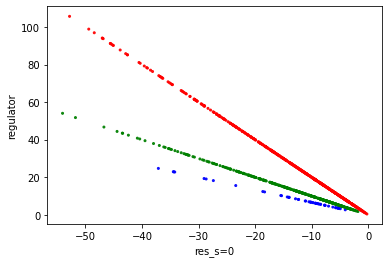

In [56]:
df_plot = df_all[df_all.class_number <= 2]
df_plot = df_plot.iloc[0:1000]
# df_plot = df_all
x = df_plot['res_s=0'].to_numpy()
y = df_plot['regulator'].to_numpy()
colors = df_all['class_number']
color_map = {0:'red', 1:'green', 2:'blue'}

f = plt.figure()
plt.scatter(x, y, s=4, alpha=0.9, c=df_plot.class_number.map(color_map))
# plt.title("class 1 (red) and class 2 (blue) for x^2 + bx + c")
plt.xlabel("res_s=0")
plt.ylabel("regulator")
plt.show()